In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
from pickle import load as Pload
from pickle import dump as Pdump
from ds_ame import Datas_ame

In [18]:
# LOAD Datas_ame()
file = open("../../data/ame_manym/SPP_p15_corrected.txt", "rb")
data_ame = Pload(file)
file.close()
print(np.shape(data_ame.Ms))
""" 
file = open("../../data/ame_manym/NN_linear_deg5_check11.txt", "rb")
data_ame2 = Pload(file)
file.close()
print(np.shape(data_ame2.Ms))
 """
file = open("../../data/SPP_p15.txt", "rb")
data = Pload(file)
file.close()
print(np.shape(data.M))


(15, 200, 17, 6)
(20, 200, 3)


## Analysis

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["o", ">", "s"]
#M_strategies = ["our_M", "qiskit_M"]
labels = ["AME", "our_M", "qiskit_M"]

## Final M value

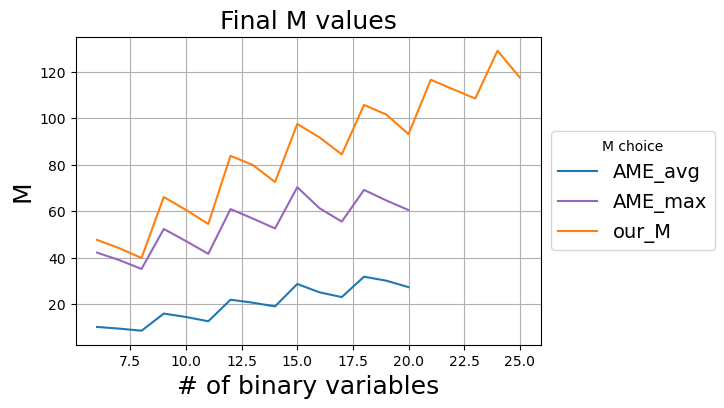

In [4]:
def statistics_M_ame(data):
    avg_max = np.mean(data.Ms.max(axis = 2).max(axis = 2), axis = 1)
    std_max = np.std(data.Ms.max(axis = 2).max(axis = 2), axis = 1)
    avg_avg = np.mean(data.Ms.max(axis = 2).mean(axis = 2), axis = 1)
    std_avg = np.std(data.Ms.max(axis = 2).mean(axis = 2), axis = 1)
    return avg_max, std_max, avg_avg, std_avg

def statistics_M(data):
    avg = np.mean(data.M, axis = 1)
    std = np.std(data.M, axis = 1)
    return avg, std

avg_max_ame, std_max_ame, avg_avg_ame, std_avg_ame = statistics_M_ame(data_ame)
avg_M, std_M = statistics_M(data)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Final M values', fontsize = 18)
ax1.set_xlabel('# of binary variables', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
plt.plot(data_ame.bvars, avg_avg_ame, color = colors[0], label = labels[0]+"_avg")
plt.plot(data_ame.bvars, avg_max_ame, color = colors[4], label = labels[0]+"_max")
#plt.fill_between(data_ame.bvars, avg_M_ame - std_M_ame, avg_M_ame + std_M_ame, color = colors[0], alpha=.2)
for i in range(1):
    plt.plot(data.bvars, avg_M[...,i], color = colors[i + 1], label = labels[i + 1])
    #plt.fill_between(data.bvars, avg_M[...,i] - std_M[...,i], avg_M[...,i] + std_M[...,i], color = colors[i + 1], alpha=.2)

""" for var_idx in range(len(data.bvars)):
    y = data.M[var_idx, :, i]
    x = data.bvars[var_idx] * np.ones((len(y)))
    plt.scatter(x, y, color = colors[i], alpha=.3) """
plt.grid()
#plt.ylim(0, 50)
#plt.xlim(5, 10)
#plt.yscale("log")
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fitting M

In [15]:
f = lambda n, a, b: a*n + b
f2 = lambda n, a, b: a*n**2 + b*n
funct = f
n_parameters = 2
n_fit = 1

start_point = 0

coef = np.ndarray((n_parameters, n_fit))
coef_cov = np.ndarray((n_parameters, n_parameters, n_fit))
coef_err = np.ndarray((n_parameters, n_fit))
for i in range(n_fit):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data_ame.bvars[start_point:], avg_M_ame[start_point:])
    coef_err[:,i] = np.sqrt( np.diag(coef_cov[...,i]) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
plt.plot(data_ame.bvars, avg_M_ame, ".", color = colors[i], label=labels[i])
plt.fill_between(data_ame.bvars, avg_M_ame - std_M_ame, avg_M_ame + std_M_ame, color = colors[i], alpha=.2)
plt.plot(data_ame.bvars, funct(data_ame.bvars, *coef[:,i]), "--", color = colors[i], label=labels[i]+" fit")
plt.grid()
#plt.ylim(0, 250)
#plt.yscale("log")
ax1.legend(fontsize = 10, loc='center right')
#ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

words = ["Ame", "Our_M", "Optimal"]
for i in range(n_fit):
    print(f"{words[i]} fit:\t{np.round(coef[0,i], 2)}x+{np.round(coef[1,i], 2)}")
    print(f"{coef[0,i]} \pm {coef_err[0,i]}")
    print(f"{coef[1,i]} \pm {coef_err[1,i]}")

NameError: name 'avg_M_ame' is not defined

### Number of steps

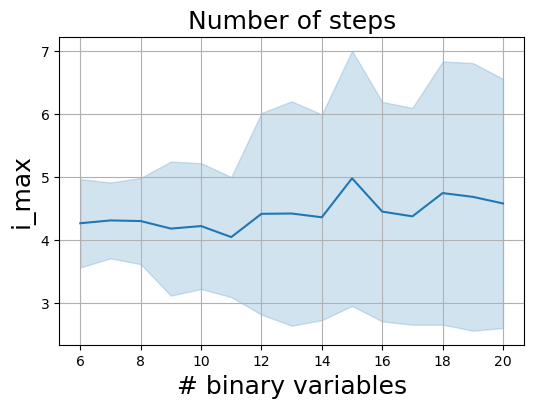

In [13]:
def statistics_steps(data):
    avg = np.mean(data.max_iter, axis = 1)
    std = np.std(data.max_iter, axis = 1)
    return avg, std

avg, std = statistics_steps(data_ame)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Number of steps', fontsize = 18)
ax1.set_xlabel('# binary variables', fontsize = 18)
ax1.set_ylabel('i_max', fontsize = 18)
plt.plot(data_ame.bvars, avg, color = colors[0], label = labels[0])
plt.fill_between(data_ame.bvars, avg - std, avg + std, color = colors[0], alpha=.2)
#plt.ylim(0,5)
plt.grid()
plt.show()

## Gap study

In [1]:
""" from run_ame import run_instance as run_instance_ame
import numpy as np
from qiskit_optimization.algorithms import OptimizationResultStatus
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model_reader import ModelReader
import warnings
from ds_ame import Problem, Datas_ame

def run_instance_old(filename, M_strategies, indexes, analyze_gaps):
    '''
    Read LP file to get problem instance, solve it both in a classic and quantum way(s) and compute the gaps
    Return:
        p - the problem instance
        xs - the results got with the M strategies
    '''
    bvars = 4
    m = ModelReader.read(filename, ignore_names=True)
    qp = from_docplex_mp(m)
    p = Problem(qp)
    p.qp.name = filename

    # solve classically
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c_res = p.solve_exact()
    if c_res.status != OptimizationResultStatus.SUCCESS:
        print(f"{filename} results to be infeasible, with status {c_res.status}")
    
    # solve quantumly
    xs = np.ndarray((len(M_strategies), bvars), dtype = int)
    for M_idx in range(len(M_strategies)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            q_res, M, t = p.solve_quantum(M_strategies[M_idx])
        xs[M_idx] = np.rint( q_res.x ).astype(int)
        # analyze gaps
        if analyze_gaps:
            H = p.get_obj_hamiltonian()
            #print("Objective only Hamiltonian, from old code:")
            #print(H)
            Hc = p.get_constraint_hamiltonian()
            H = H + M*Hc # that's all diagonal!
            #print("Objective + Constr. Hamiltonian, from old code:")
            #print(H)
            evs = np.unique(H) # already ordered
            gap = (evs[1] - evs[0])/(evs[-1] - evs[0]) # dividing by spectral width gives gap of Hamiltonian shifted and squeezed s.t. spectrum is in [0,1]
            print("Our Gap, from old code:")
            print(gap)
    return p, xs


filename = "../../toys/NN_linear_deg5/4/random1043_4_1.lp"
filename = "../../toys/NN_linear_deg5/4/random10642_4_1.lp"

d = Datas_ame([4], 1)
p = run_instance_ame(filename, d, [0,0], True)

p2, _ = run_instance_old(filename, ["our_M"], [0,0], True) """

Our M:	0.5416667660134076

Our Gap, from AME code:
0.03288889038094449
Our Gap, from old code:
0.03288889038094445


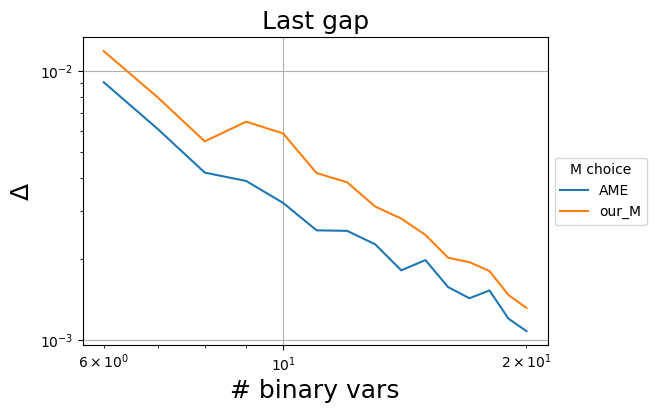

In [5]:
def statistics_last_gap_ame(data):
    n_vars, n_samples, _ = np.shape(data.fvals)
    last_gap = np.ndarray((n_vars, n_samples))
    for i in range(n_vars):
        for j in range(n_samples):
            last_gap[i, j] = data.gaps[i, j, data.max_iter[i,j]-1]
    return np.mean(last_gap, axis = 1), np.std(last_gap, axis = 1)

def statistics_gaps_our(data):
    avg_k = np.mean(data.gap_norm[..., 0], axis = 1)
    std_k = np.std(data.gap_norm[..., 0], axis = 1)
    return avg_k, std_k

avg_our, std_our = np.mean(data_ame.our_gap, axis = 1), np.std(data_ame.our_gap, axis = 1)

avg_d_ame, std_d_ame = statistics_last_gap_ame(data_ame)
avg_d, std_d = statistics_gaps_our(data)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Last gap', fontsize = 18)
ax1.set_xlabel('# binary vars', fontsize = 18)
ax1.set_ylabel('$\Delta$', fontsize = 18)
plt.plot(data_ame.bvars, avg_d_ame, label = labels[0])
plt.plot(data_ame.bvars, avg_our, label = labels[1])
#plt.fill_between(data_ame.bvars, avg_d_ame - std_d_ame, avg_d_ame + std_d_ame, alpha = .2)
plt.grid()
plt.yscale("log")
plt.xscale("log")
ax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [6]:
def compute_gap_cost(data):
    n_vars, n_samples, _ = np.shape(data.fvals)
    cost = np.ndarray((n_vars, n_samples))
    for i in range(n_vars):
        for j in range(n_samples):
            cost[i, j] = np.sum( 1/data.gaps[i, j, :data.max_iter[i,j]] )
    return cost

cost_ame = compute_gap_cost(data_ame)
cost_our = (1/data.gap_norm[..., 0])
cost_qiskit = (1/data.gap_norm[..., 1])

#### Comparison AME1M, AMEmm

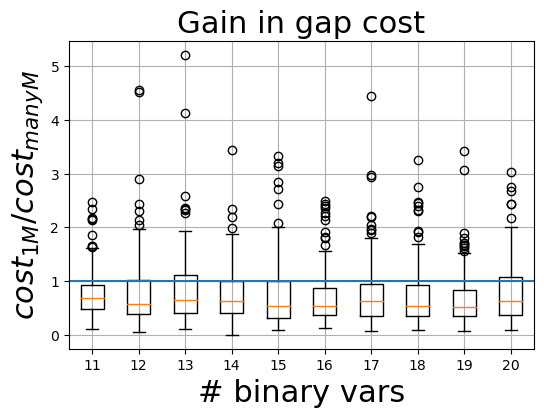

In [7]:
file = open("../../data/ame_manym/SPP_p15_corrected.txt", "rb")
data_ame_many = Pload(file)
file.close()

file = open("../../data/ame/SPP_p15.txt", "rb")
data_ame_one = Pload(file)
file.close()

cost_ame_one = compute_gap_cost(data_ame_one)
cost_ame_many = compute_gap_cost(data_ame_many)

ratio_cost = cost_ame_one[:-5] / cost_ame_many

vars_to_plot = list(np.arange(-10, 0))

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gain in gap cost', fontsize = 22)
ax1.set_xlabel('# binary vars', fontsize = 22)
ax1.set_ylabel('$cost_{1M} / cost_{manyM}$', fontsize = 22)
ax1.boxplot(np.swapaxes(ratio_cost[vars_to_plot], axis1=0, axis2=1), labels = data_ame_many.bvars[vars_to_plot])
#plt.ylim(0,10)
plt.axhline(1)
plt.grid()
plt.show()

#### Comparison AMEmm, Our_M

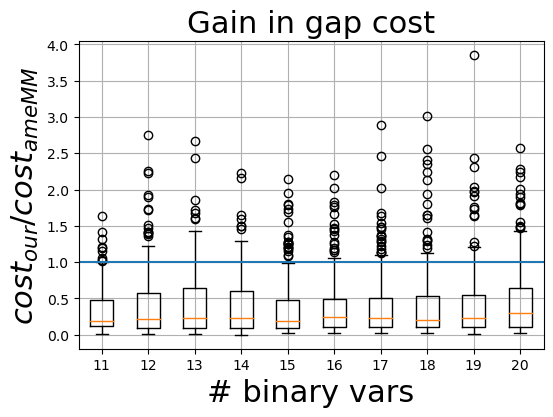

In [11]:
vars_to_plot = list(np.arange(-10, 0))
ratio_cost = cost_our[:-5] / cost_ame

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gain in gap cost', fontsize = 22)
ax1.set_xlabel('# binary vars', fontsize = 22)
ax1.set_ylabel('$cost_{our} / cost_{ameMM}$', fontsize = 22)
ax1.boxplot(np.swapaxes(ratio_cost[vars_to_plot], axis1=0, axis2=1), labels = data_ame.bvars[vars_to_plot])
#plt.ylim(0,10)
plt.axhline(1)
plt.grid()
plt.show()

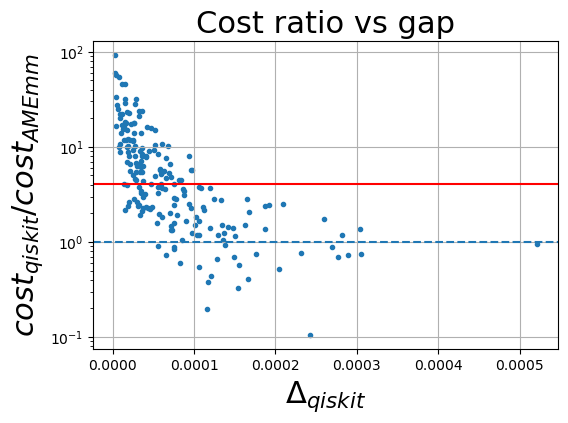

In [15]:
cost_our_last = cost_our[-1]
cost_qiskit_last = cost_qiskit[-1]
cost_ame_last = cost_ame[-1]

M_idx = 1 # M_strategy to compare with: 0 -> our_M ; 1 -> qiskit_M 

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Cost ratio vs gap', fontsize = 22)
if M_idx == 0:
    med = np.median(cost_our_last/cost_ame_last)
    ax1.set_xlabel('$\Delta_{our}$', fontsize = 22)
    ax1.set_ylabel('$cost_{our} / cost_{AMEmm}$', fontsize = 22)
    plt.scatter(data.gap_norm[-1,:,0], cost_our_last/cost_ame_last, marker = ".")
elif M_idx == 1:
    med = np.median(cost_qiskit_last/cost_ame_last)
    ax1.set_xlabel('$\Delta_{qiskit}$', fontsize = 22)
    ax1.set_ylabel('$cost_{qiskit} / cost_{AMEmm}$', fontsize = 22)
    plt.scatter(data.gap_norm[-1,:,1], cost_qiskit_last/cost_ame_last, marker = ".")
    plt.yscale("log")
#plt.ylim(0,10)
plt.axhline(1, linestyle = "--")
plt.axhline(med, color = "r")
plt.grid()
plt.show()

### Fit of gaps

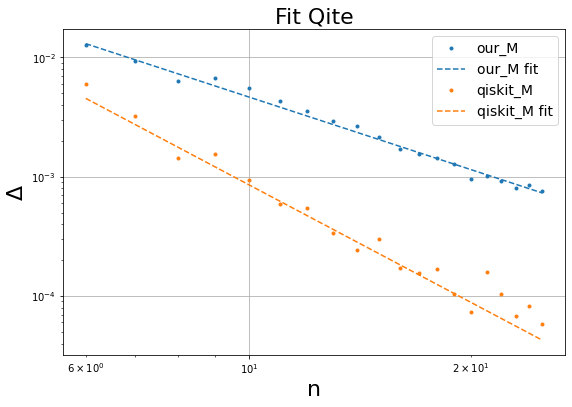

Our fit: 0.48 x^-2.02
a:	0.483 \pm 0.564
b:	-2.018 \pm 0.446

Qiskit fit: 1.58 x^-3.27
a:	1.581 \pm 2.793
b:	-3.268 \pm 0.68



In [43]:
f_pl = lambda x, a, b : a*x**b
f_exp = lambda x, a, b : a*b**x
funct = f_pl

n_parameters = 2
endpoint = 22
startpoint = 0
n_M = 2

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[startpoint:endpoint], avg_gap_qite[startpoint:endpoint,i],
                                sigma = std_gap_qite[startpoint:endpoint,i],
                                absolute_sigma = True)
    coef_err[:,i] = np.sqrt(np.diag(coef_cov[...,i]))
# sigma in curve_fit gives the uncertainty in ydata

def RSS(x, y, f):
    return np.sum( np.square(y - f(x)) )

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Fit Qite', fontsize = 22)
ax1.set_xlabel('n', fontsize = 22)
ax1.set_ylabel('$\Delta$', fontsize = 22)
for i in range(n_M):
    if plot_M[i]:
        #plt.plot(data.bvars[:10], avg_gap_adiabatic[:10,i], label=M_strategies[i]+" Adiab",  color = colors[i])
        plt.plot(data.bvars[:endpoint], avg_gap_qite[:endpoint,i], ".", label=M_strategies[i],  color = colors[i])
        """ plt.fill_between(data.bvars[:endpt_qite], avg_gap_qite[:endpt_qite,i] - std_gap_qite[:endpt_qite,i],
                         avg_gap_qite[:endpt_qite,i] + std_gap_qite[:endpt_qite,i], alpha=.2,  color = colors[i]) """
        plt.plot(data.bvars[:endpoint], funct(data.bvars[:endpoint], *coef[:,i]), "--", color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.ylim(0, .05)
#plt.xlim(9, 26)
ax1.legend(fontsize = 14, loc='upper right')
plt.show() 


word = ["Our", "Qiskit", "Optimal"]
for i in range(n_M):
    print(f"{word[i]} fit: {np.round(coef[0,i], 2)} x^{np.round(coef[1,i], 2)}")
    print(f"a:\t{np.round(coef[0,i], 3)} \pm {np.round(coef_err[0,i], 3) }")
    print(f"b:\t{np.round(coef[1,i], 3)} \pm {np.round(coef_err[1,i], 3) }\n")
    #r = RSS( data.bvars[startpoint:endpoint], avg_gap_qite[startpoint:endpoint,i], lambda x : funct(x, *coef[:,i]))
    #print(f"RSS (wrt mean) value {np.round(r, 7)}")

In [2]:
""" file = open("../../data/ame_manym/NN_linear_deg5.txt", "rb")
data_base = Pload(file)
file.close()

file = open("../../data/ame_manym/NN_linear_deg5_25.txt", "rb")
data_extend = Pload(file)
file.close()

bvars_extend = np.arange(25, 26)

def glue_datas_bybvars(data_base, data_extend, bvars_extend):
    break_idx = len(bvars_extend)
    _, n_samples = np.shape(data_extend.is_optimum)
    bvars = np.append(data_base.bvars, bvars_extend)
    data = Datas_ame(bvars, n_samples)
    data.is_optimum[:- break_idx ] = data_base.is_optimum
    data.is_optimum[- break_idx :] = data_extend.is_optimum
    data.fval_classic[:- break_idx ] = data_base.fval_classic
    data.fval_classic[- break_idx :] = data_extend.fval_classic
    data.max_iter[:- break_idx ] = data_base.max_iter
    data.max_iter[- break_idx :] = data_extend.max_iter
    data.our_gap[:- break_idx ] = data_base.our_gap
    data.our_gap[- break_idx :] = data_extend.our_gap
    data.num_const[:- break_idx ] = data_base.num_const
    data.num_const[- break_idx :] = data_extend.num_const

    # strucs depending on max_iter
    _, _, max_iter_base, max_ncons_base = np.shape(data_base.Ms)
    _, _, max_iter_extend, max_ncons_extend = np.shape(data_extend.Ms)
    max_iter_tot = max(max_iter_base, max_iter_extend)
    max_ncons_tot = max(max_ncons_base, max_ncons_extend)
    data.gaps, data.fvals = np.zeros((len(bvars), n_samples, max_iter_tot)), np.zeros((len(bvars), n_samples, max_iter_tot))
    data.Ms, data.violation_nums = np.zeros((len(bvars), n_samples, max_iter_tot, max_ncons_tot)), np.zeros((len(bvars), n_samples, max_iter_tot, max_ncons_tot))
 
    data.gaps[:- break_idx , :, :max_iter_base] = data_base.gaps
    data.gaps[- break_idx :, :, :max_iter_extend] = data_extend.gaps
    data.fvals[:- break_idx , :, :max_iter_base] = data_base.fvals
    data.fvals[- break_idx :, :, :max_iter_extend] = data_extend.fvals
    data.Ms[:- break_idx , :, :max_iter_base, :max_ncons_base] = data_base.Ms
    data.Ms[- break_idx :, :, :max_iter_extend, :max_ncons_extend] = data_extend.Ms
    data.violation_nums[:- break_idx , :, :max_iter_base, :max_ncons_base] = data_base.violation_nums
    data.violation_nums[- break_idx :, :, :max_iter_extend, :max_ncons_extend] = data_extend.violation_nums
    return data


data = glue_datas_bybvars(data_base, data_extend, bvars_extend)

file = open("../../data/ame_manym/NN_linear_deg5_tot.txt", "wb")
Pdump(data, file)
file.close() """